# Kepler Equation

In this notebook, I explore the use of Pade approximants to improve the order-by-order convergence of series expansions of the Kepler equation:

$$E(t) = M(t) + e \sin E(t)$$

where $t$ is time, $E$ is the eccentric anomaly, $M$ is the mean anomaly, and $e$ is the orbital eccentricity. Because this is a transcendental equation, there doesn't exist a clean analytic solution. 

A common way to solve the equation is via an iterative root-finding method. That is, one looks for the root of the equation:

$$ E(t) - e \sin E(t) - M(t) $$

via some root-finding method. In this notebook, we use the popular and simple Newton_Raphson method and treat its output as a benchmark for comparing the accuracy of our series expansions.

Series expansion for $e$ is given as:

$$E = M + \sum_{n=1}^{\infty} a_n e^n$$

where

$$a_n = \frac{1}{2^{n-1} n!} \sum_{k=0}^{\lfloor n / 2\rfloor} (-1)^k \binom{n}{k}(n - 2k)^{n-1} \sin[(n - 2k)M]$$ 

In [241]:
# get nth taylor expansion coefficient (assuming x = 0.5)
def taylor_coeff_func_eccentricity(n, M=0.25):
    if n == 0:
        return M
    else:
        prefac = 1. / (math.pow(2., n -1) * math.factorial(n))

        running_sum = 0
        
        for k in range(0, math.floor(n/2) + 1):
            term1 = math.pow(-1., k) * scipy.special.binom(n, k)
            term2 = math.pow(n - 2.*k, n-1.) * math.sin((n - 2.*k) * M)
            running_sum += (term1 * term2)
            
        return running_sum * prefac

In [238]:
#### import necessary libraries 
import math
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.special

# set custom plotting values
mpl.rcParams['figure.figsize'] = (16,8)
mpl.rcParams['lines.linewidth'] = 4
mpl.rcParams['axes.labelsize'] = 20
mpl.rcParams['xtick.labelsize'] = 20 
mpl.rcParams['ytick.labelsize'] = 20 
mpl.rcParams['xtick.major.size'] = 10
mpl.rcParams['ytick.major.size'] = 10
mpl.rcParams['lines.markersize'] = 1000
mpl.rcParams['legend.fontsize'] = 18

In [1]:
def optimal_Newton_E0(M, e):
    
    if e >=1:
        print("Cannot use initial E0 function with e >= 1")
        SystemExit
    
    if M >= 0 and M < 0.25:
        E_0 = M + e*e * (math.pow(6.*M, 1./3.) - M)
    elif M >= 0.25 and M <= math.pi:
        numer = e * math.sin(M)
        denom = 1. - math.sin(M + e) + math.sin(M)
        E_0 = M + (numer/denom)
    else:
        print("M out of bounds")
        SystemExit
    
    return E_0

In [95]:
def Newton_Raphson(e, M, desired_accuracy):
    
    E_0 = optimal_Newton_E0(M, e)
    
    E_i = E_0
    E_j = Newton_Raphson_Iteration(E_i, e, M)
    
    while (abs(E_i - E_j) > desired_accuracy):
        E_i = E_j
        E_j = Newton_Raphson_Iteration(E_i, e, M)
    
    return E_j
    

def Newton_Raphson_Iteration(E_i, e, M):
    func_deriv_quotient_numer = E_i - e * math.sin(E_i) - M
    func_deriv_quotient_denom = 1. - e * math.cos(E_i)
    func_deriv_quotient = func_deriv_quotient_numer / func_deriv_quotient_denom
    
    E_j = E_i - func_deriv_quotient
    
    return E_j

In [75]:
e = 0.95
M = 0.5
accuracy_values = [1/10**x for x in range(0, 16)]
Newton_values = [Newton_Raphson(e, M, x) - Newton_Raphson(e, M, accuracy_values[-1]) for x in accuracy_values]

Text(0,0.5,'Absolute Difference')

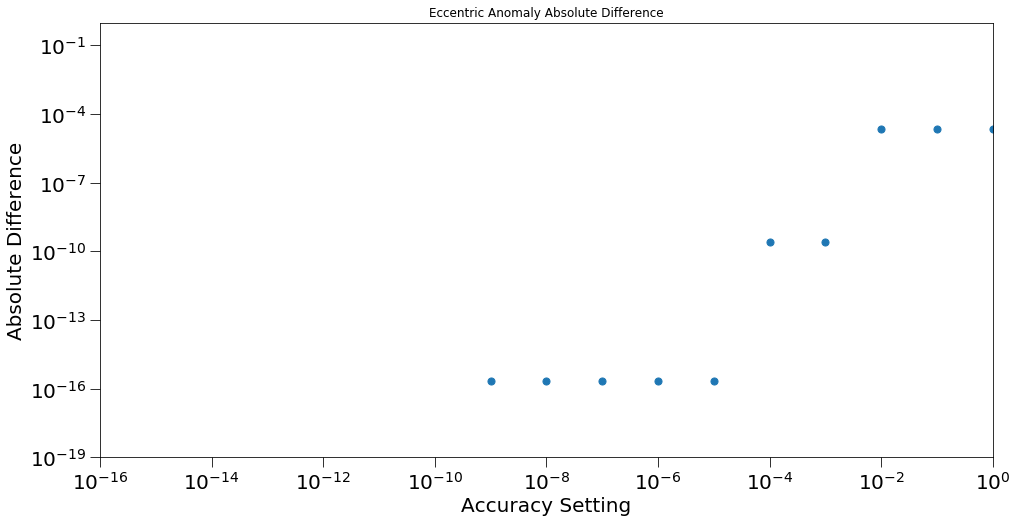

In [77]:
plt.scatter(accuracy_values, Newton_values, s = 50)
plt.xlim([1e-16, 1])
plt.ylim([1e-19, 1])
plt.xscale('log')
plt.yscale('log')
plt.title('Eccentric Anomaly Absolute Difference')
plt.xlabel('Accuracy Setting')
plt.ylabel('Absolute Difference')

As can be seen, we 

In [133]:
laplace_limit = 0.66274

In [229]:
# get nth taylor expansion coefficient (assuming x = 0.5)
def taylor_coeff_func_eccentricity_2(n, M=0.25):
    if n == 0:
        return M
    elif n == 1:
        return math.sin(M)
    elif n == 2:
        return (1./2.) * math.sin(2.*M)
    elif n == 3:
        return (-1./8.) * (math.sin(M) - 3. * math.sin(3.*M))
    elif n == 4:
        return (1./3.) * math.sin(4.*M) - (1./6.) * math.sin(2.*M)
    elif n == 5:
        return (125/384) * math.sin(5.*M) + math.sin(M)/192 - (27/128) * math.sin(3*M)
    elif n == 6:
        return math.sin(2*M)/48 + (27/80)*math.sin(6*M) - (4/15)*math.sin(4*M)
    elif n == 7:
        pass

In [141]:
# get array of taylor expansion coefficients
def get_array_taylor_coeff(order, taylor_coeff_func):
    taylor_coeffs = np.zeros(order)
    
    for n in range (0, order):
        taylor_coeffs[n] = taylor_coeff_func(n)
    
    return taylor_coeffs

In [98]:
# function to return the sum of a power series in x^n
def get_pade_polynomial(coeffs, x, order):    
    pade_sum = 0
    
    for idx in range(0, order+1):
        term = coeffs[idx] * math.pow(x, idx)
        pade_sum += term

    return pade_sum

# create the coupled equation matrix to determine pade approximant coefficients for [n,n]
def create_pade_matrix(taylor_coeffs, order):
    
    pade_matrix = np.zeros((order+1, order+1))
    
    qIdxStart = int(order/2 + 1)
        
    # set diagonal element
    for idx in range(0, qIdxStart):
        pade_matrix[idx,idx] = -1
    
    for row in range (0, order+1):
        taylorIdx = row - 1
                        
        for qIdx in range (0, row):
            qMatrixIdx = qIdxStart + qIdx
            
            if (qMatrixIdx > order):
                continue
            
            pade_matrix[row, qMatrixIdx] = taylor_coeffs[taylorIdx]
            taylorIdx -= 1
            
                        
    return pade_matrix   

In [99]:
# return the [n,n] pade approximant
def pade_approximant(z, order, taylor_coeff_func):
        
    pade_order = int(order/2)

    taylor_coeffs = get_array_taylor_coeff(order+1, taylor_coeff_func)
    pade_matrix = create_pade_matrix(taylor_coeffs, order)
    a = pade_matrix
    b = -1 * taylor_coeffs
    pade_coeffs = np.linalg.solve(a, b)

    p_coeffs = pade_coeffs[0:pade_order+1]
    q_coeffs = np.zeros(pade_order + 1)
    q_coeffs[0] = 1
    qIdx = 1
    for idx in range(pade_order + 1, order+1):
        q_coeffs[qIdx] = pade_coeffs[idx]
        qIdx += 1

    pade_numer = get_pade_polynomial(p_coeffs, z, pade_order)
    pade_denom = get_pade_polynomial(q_coeffs, z, pade_order)
    
    return (pade_numer / pade_denom)

# Eccentricity Expansion

In [247]:
ecc_values = [x / 100 for x in range(1, 100)]
M = 0.25

# Newton = []
expand_0 = []
expand_1 = []
expand_2 = []
expand_3 = []
expand_4 = []
expand_5 = []
expand_6 = []
expand_7 = []
expand_8 = []
expand_9 = []
expand_10 = []
expand_11 = []
expand_12 = []
expand_13 = []


pade_1 = []
pade_2 = []
pade_3 = []
pade_4 = []
pade_5 = []
pade_6 = []

# zero_taylor = get_array_taylor_coeff(0, taylor_coeff_func_eccentricity):
# one_taylor = get_array_taylor_coeff(1, taylor_coeff_func_eccentricity):
# two_taylor = get_array_taylor_coeff(2, taylor_coeff_func_eccentricity):
taylor_coeffs = get_array_taylor_coeff(14, taylor_coeff_func_eccentricity)

for ecc in ecc_values:
    truth = Newton_Raphson(ecc, M, 1e-15)
    expand_0.append(abs(truth - get_pade_polynomial(taylor_coeffs, ecc, 0)))
    expand_1.append(abs(truth - get_pade_polynomial(taylor_coeffs, ecc, 1)))
    expand_2.append(abs(truth - get_pade_polynomial(taylor_coeffs, ecc, 2)))
    expand_3.append(abs(truth - get_pade_polynomial(taylor_coeffs, ecc, 3)))
    expand_4.append(abs(truth - get_pade_polynomial(taylor_coeffs, ecc, 4)))
    expand_5.append(abs(truth - get_pade_polynomial(taylor_coeffs, ecc, 5)))
    expand_6.append(abs(truth - get_pade_polynomial(taylor_coeffs, ecc, 6)))
    expand_7.append(abs(truth - get_pade_polynomial(taylor_coeffs, ecc, 7)))
    expand_8.append(abs(truth - get_pade_polynomial(taylor_coeffs, ecc, 8)))
    expand_9.append(abs(truth - get_pade_polynomial(taylor_coeffs, ecc, 9)))
    expand_10.append(abs(truth - get_pade_polynomial(taylor_coeffs, ecc, 10)))
    expand_11.append(abs(truth - get_pade_polynomial(taylor_coeffs, ecc, 11)))
    expand_12.append(abs(truth - get_pade_polynomial(taylor_coeffs, ecc, 12)))
    expand_13.append(abs(truth - get_pade_polynomial(taylor_coeffs, ecc, 13)))

    pade_1.append(abs(truth - pade_approximant(ecc, 2, taylor_coeff_func_eccentricity)))
    pade_2.append(abs(truth - pade_approximant(ecc, 4, taylor_coeff_func_eccentricity)))
    pade_3.append(abs(truth - pade_approximant(ecc, 6, taylor_coeff_func_eccentricity)))
    pade_4.append(abs(truth - pade_approximant(ecc, 8, taylor_coeff_func_eccentricity)))
    pade_5.append(abs(truth - pade_approximant(ecc, 10, taylor_coeff_func_eccentricity)))
    pade_6.append(abs(truth - pade_approximant(ecc, 12, taylor_coeff_func_eccentricity))) 

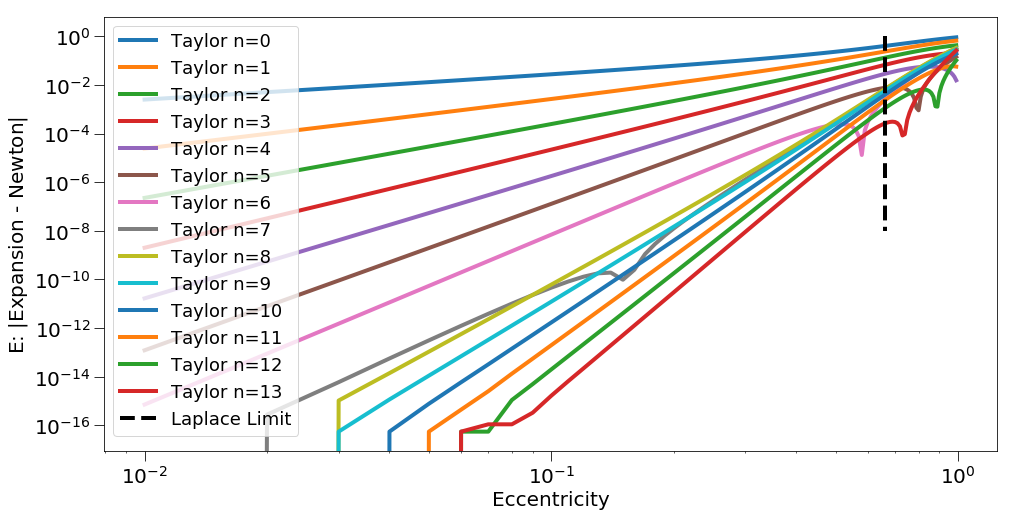

In [248]:
plt.plot(ecc_values, expand_0, label= 'Taylor n=0')
plt.plot(ecc_values, expand_1, label= 'Taylor n=1')
plt.plot(ecc_values, expand_2, label= 'Taylor n=2')
plt.plot(ecc_values, expand_3, label= 'Taylor n=3')
plt.plot(ecc_values, expand_4, label= 'Taylor n=4')
plt.plot(ecc_values, expand_5, label= 'Taylor n=5')
plt.plot(ecc_values, expand_6, label= 'Taylor n=6')
plt.plot(ecc_values, expand_7, label= 'Taylor n=7')
plt.plot(ecc_values, expand_8, label= 'Taylor n=8')
plt.plot(ecc_values, expand_9, label= 'Taylor n=9')
plt.plot(ecc_values, expand_10, label= 'Taylor n=10')
plt.plot(ecc_values, expand_11, label= 'Taylor n=11')
plt.plot(ecc_values, expand_12, label= 'Taylor n=12')
plt.plot(ecc_values, expand_13, label= 'Taylor n=13')

plt.plot([laplace_limit, laplace_limit], [1, 1e-8], 'k--', label='Laplace Limit')
plt.xlabel('Eccentricity')
plt.ylabel('E: $|$Expansion - Newton$|$')
plt.yscale('log')
plt.xscale('log')
plt.legend()

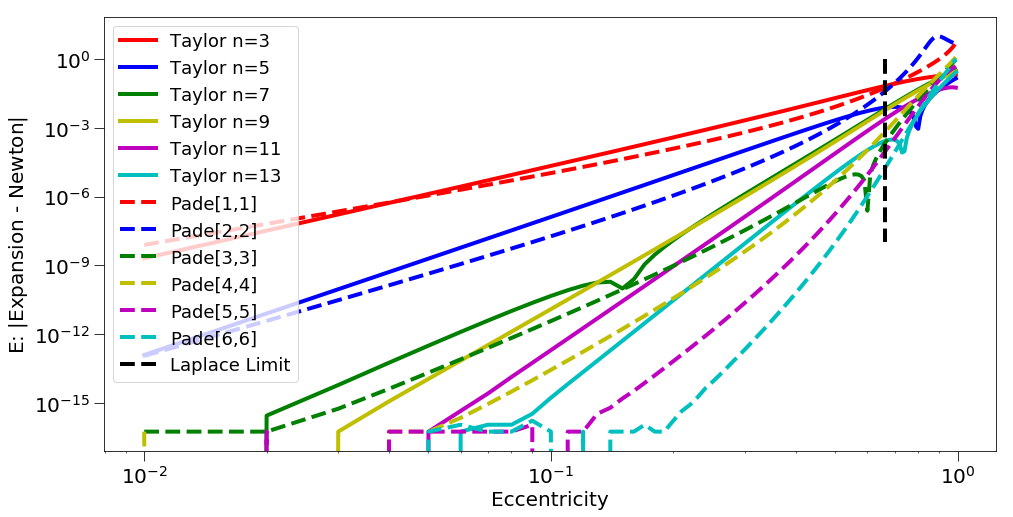

In [261]:
plt.plot(ecc_values, expand_3, 'r', label= 'Taylor n=3')
plt.plot(ecc_values, expand_5, 'b', label= 'Taylor n=5')
plt.plot(ecc_values, expand_7, 'g', label= 'Taylor n=7')
plt.plot(ecc_values, expand_9, 'y', label= 'Taylor n=9')
plt.plot(ecc_values, expand_11, 'm', label= 'Taylor n=11')
plt.plot(ecc_values, expand_13, 'c', label= 'Taylor n=13')
plt.plot(ecc_values, pade_1, 'r--', label = 'Pade[1,1]')
plt.plot(ecc_values, pade_2, 'b--', label = 'Pade[2,2]')
plt.plot(ecc_values, pade_3, 'g--', label = 'Pade[3,3]')
plt.plot(ecc_values, pade_4, 'y--', label = 'Pade[4,4]')
plt.plot(ecc_values, pade_5, 'm--', label = 'Pade[5,5]')
plt.plot(ecc_values, pade_6, 'c--', label = 'Pade[6,6]')

plt.plot([laplace_limit, laplace_limit], [1, 1e-8], 'k--', label='Laplace Limit')
plt.xlabel('Eccentricity')
plt.ylabel('E: $|$Expansion - Newton$|$')
plt.yscale('log')
plt.xscale('log')
plt.legend()